import sys
sys.path.append('../python')
%run ../python/setenv.py


In [6]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../python')
from functions import *
from models import *
import tensorflow as tf
from tqdm import *
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3" 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)






The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


# Part 1: Train on a simulated stream

In [3]:
save_folder = "test_simulated"

if save_folder is not None: 
    os.makedirs(save_folder, exist_ok=True)

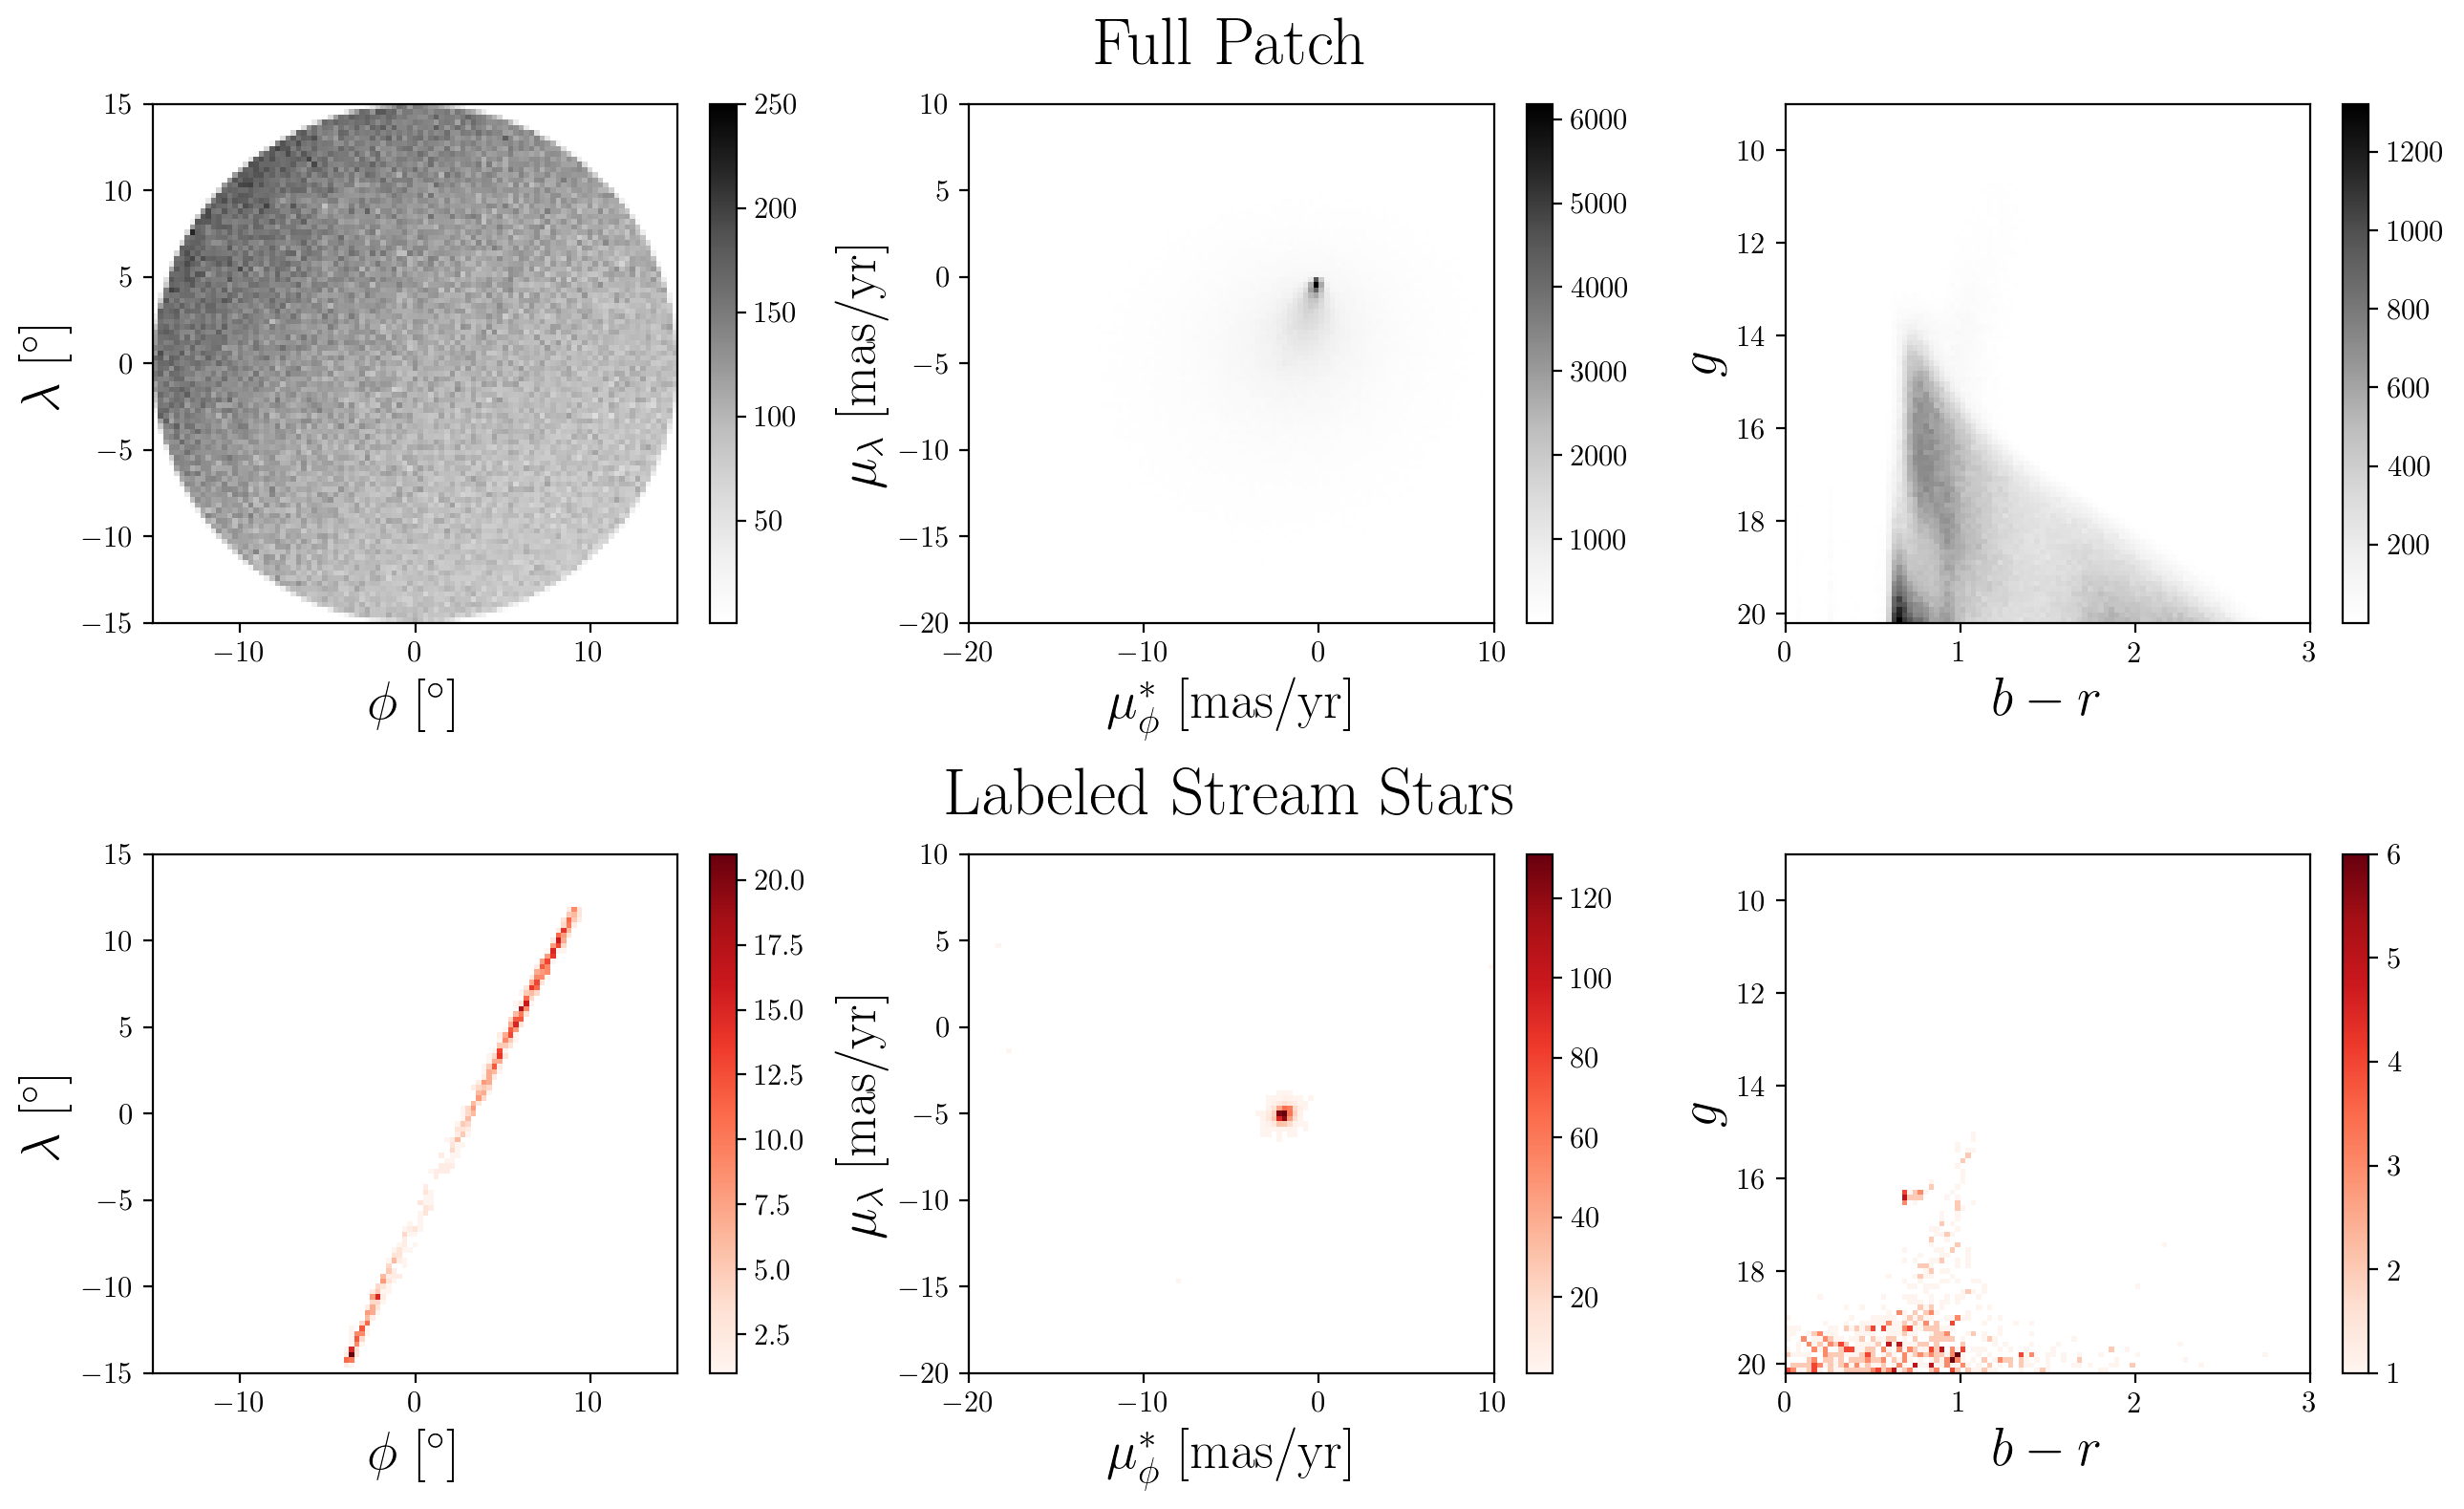

In [4]:
### Load file 
df = pd.read_hdf("../gaia_data/simulated_patch.h5")
make_plots(df, save_folder = save_folder)

Scanning over μ_λ
Sideband region: [-7.6,-6.3) & (-3.8,-2.6]
Signal region: [-6.3,-3.8]
Total counts: SR = 175,789, SB = 171,400
Signal region has 1,124 stream and 174,665 bkg events (0.64%).
Sideband region has 3 stream and 171,397 bkg events (0.00%).
f_sig = 367.7X f_sideband.


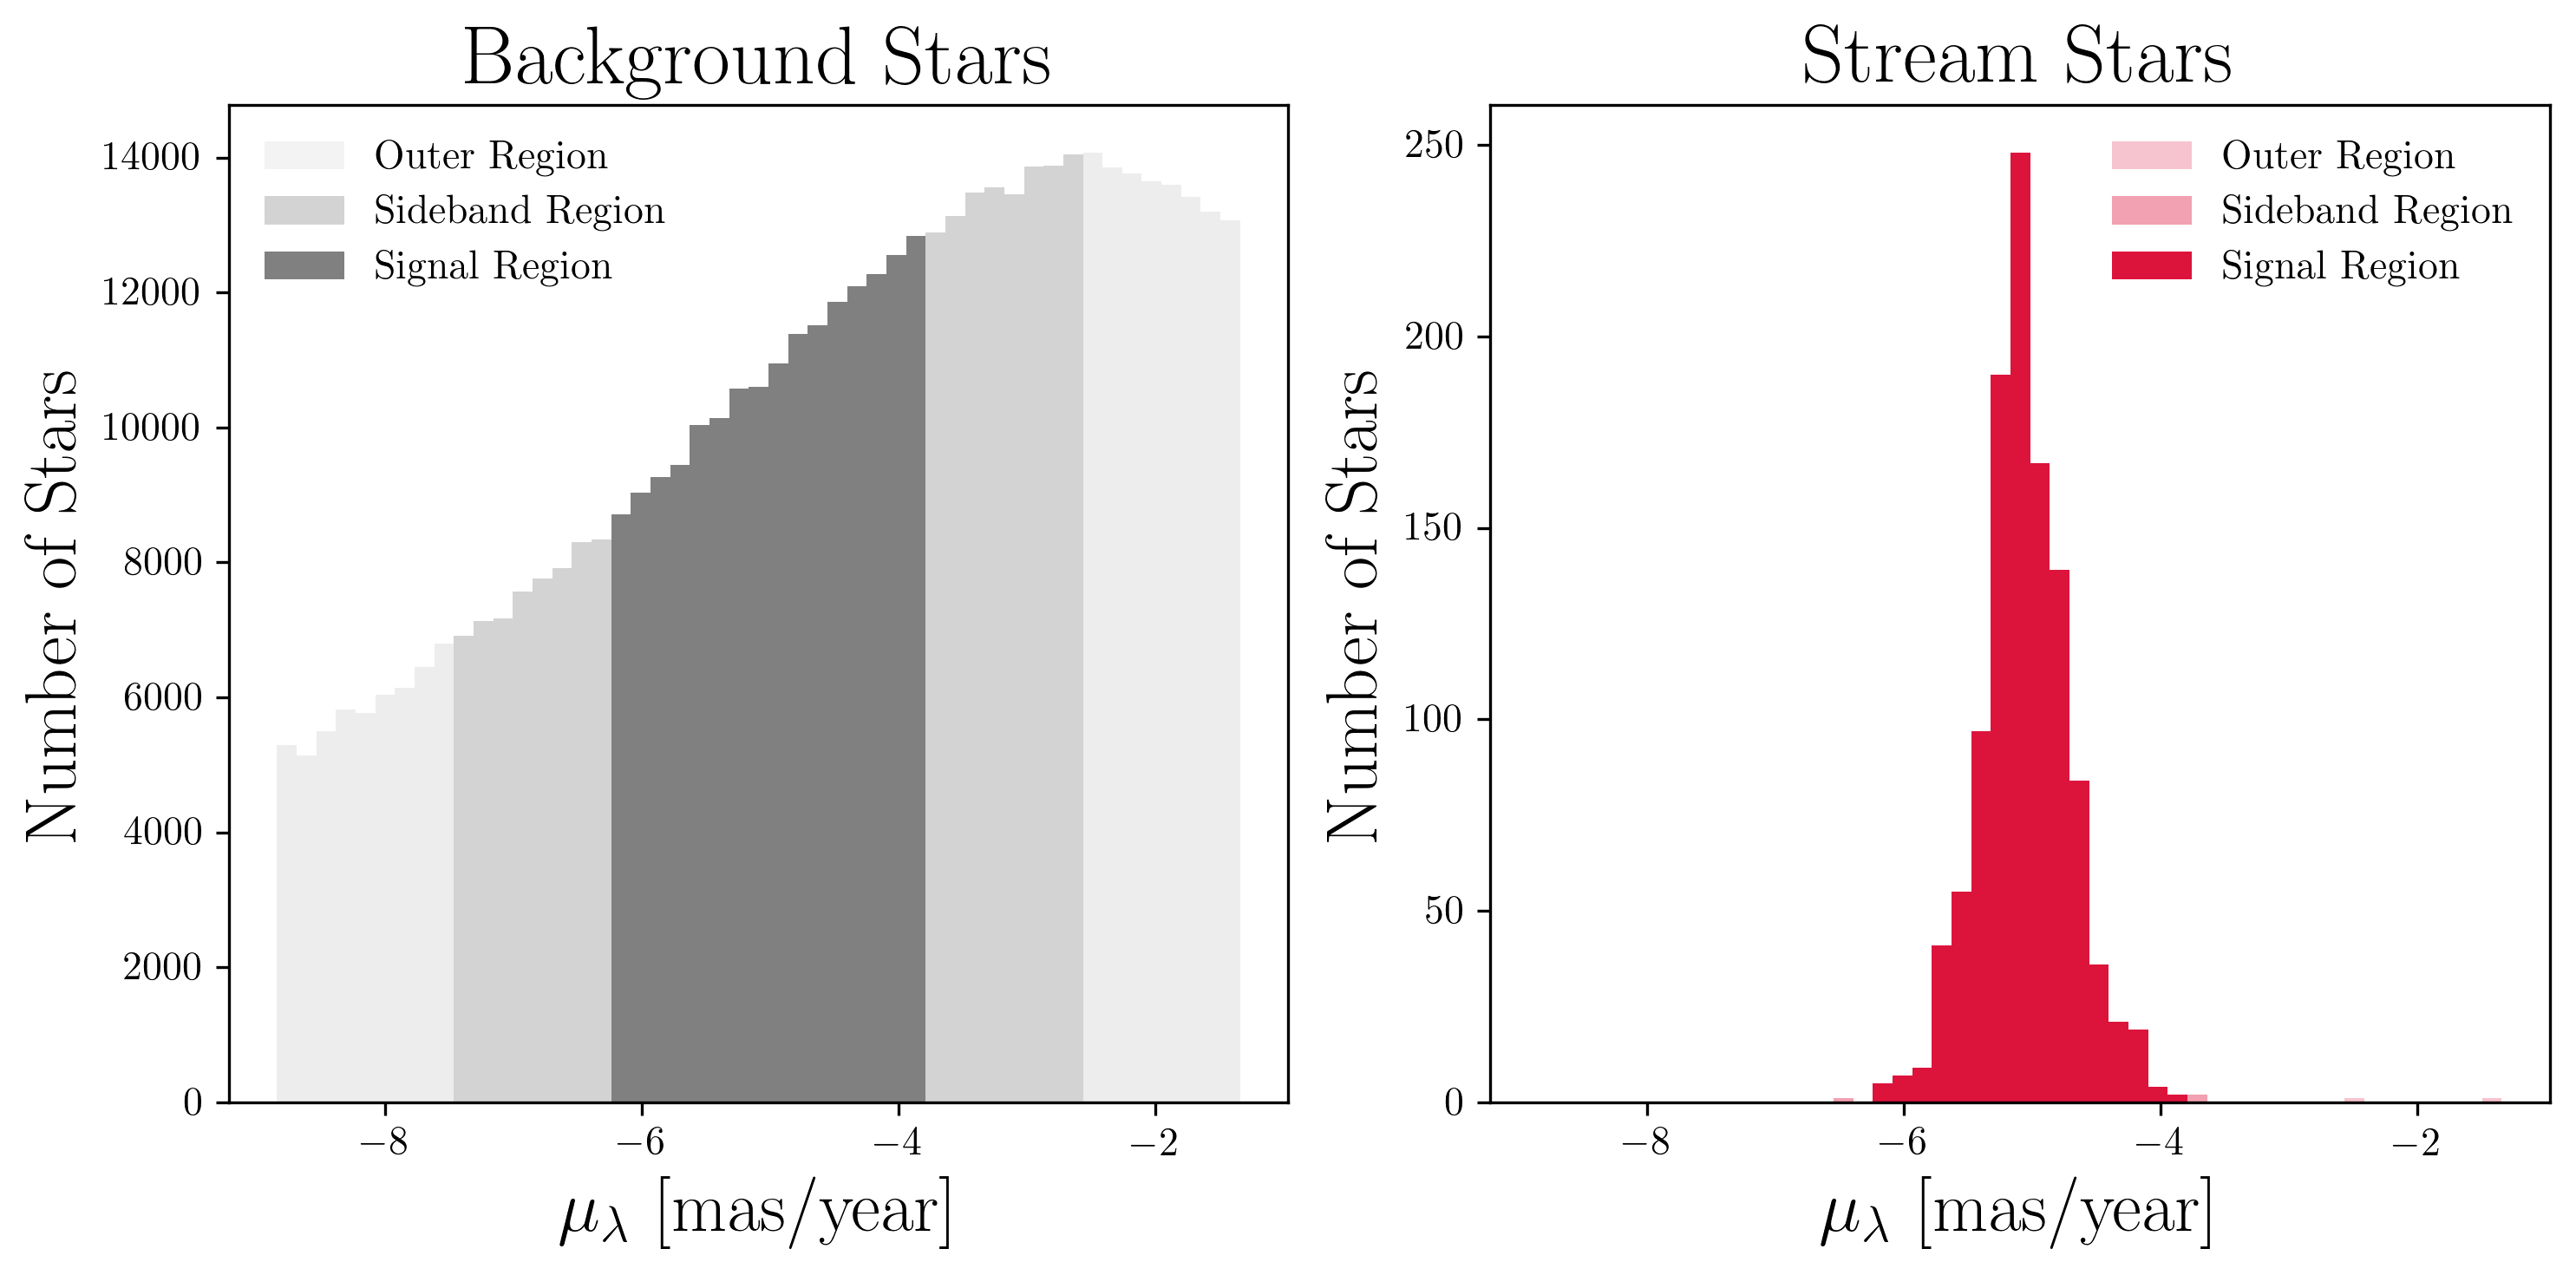

In [5]:
### Divide into signal & sideband regions. Note that these tend to be much narrower than for real streams
# df_slice = signal_sideband(df, save_folder = save_folder, sr_factor=0.25, sb_factor=0.5)
processor = SignalSideband(df,sr_factor=0.25, sb_factor=0.5)
# processor.set_factors(sr_factor=0.15, sb_factor=0.6,verbose=False)
processor.process_data()

df_slice = processor.df_slice
processor.plot_sb_data(save_folder=save_folder)


In [13]:
import time
time.time()

1693507082.9646826

2023-08-31 11:39:22.874615: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43672 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:c1:00.0, compute capability: 8.6


2170/2170 [==============================] - 2s 855us/step
Plotting results before fiducial cuts...
2170/2170 [==============================] - 2s 809us/step
Plotting results before fiducial cuts...
2170/2170 [==============================] - 2s 781us/step
Plotting results before fiducial cuts...
2170/2170 [==============================] - 2s 977us/step
Plotting results before fiducial cuts...
2170/2170 [==============================] - 2s 812us/step
Plotting results before fiducial cuts...


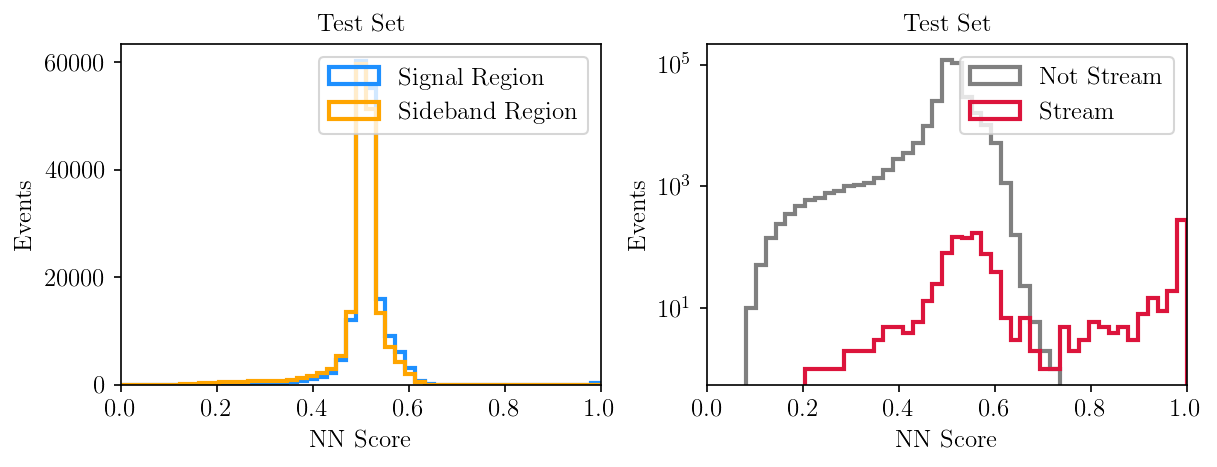

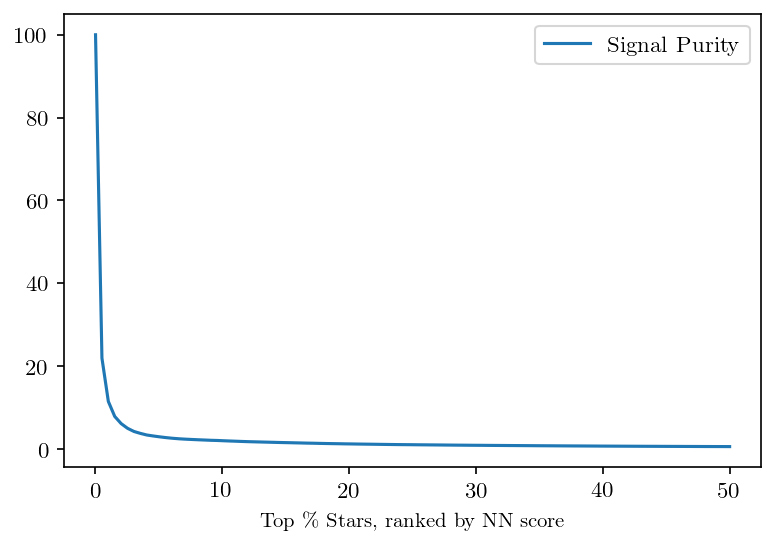

Top 50 stars: Purity = 100.0% 


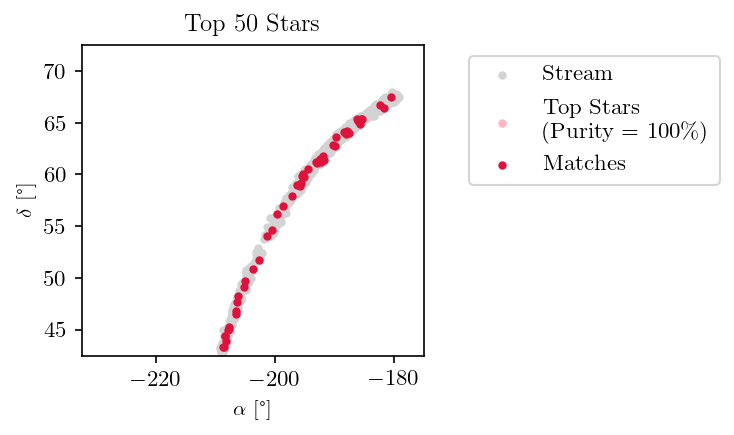

Top 100 stars: Purity = 100.0% 


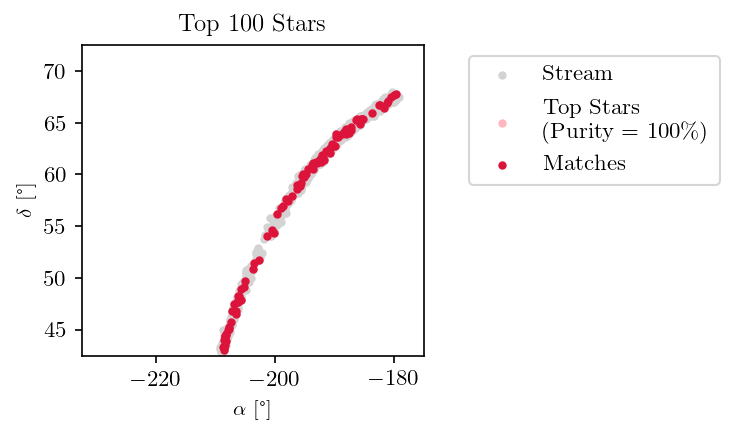

328.7546730041504

In [14]:
### Train (takes ~15 minutes to run on a GPU)
import time
start_time=time.time()
tf.keras.backend.clear_session()
test = train(df_slice, verbose=False, apply_cuts = False, save_folder = save_folder)

time.time()-start_time

# Part 2: Train on a real patch of the GD-1 stream

In [15]:
save_folder = "test_gd1"

if save_folder is not None: 
    os.makedirs(save_folder, exist_ok=True)

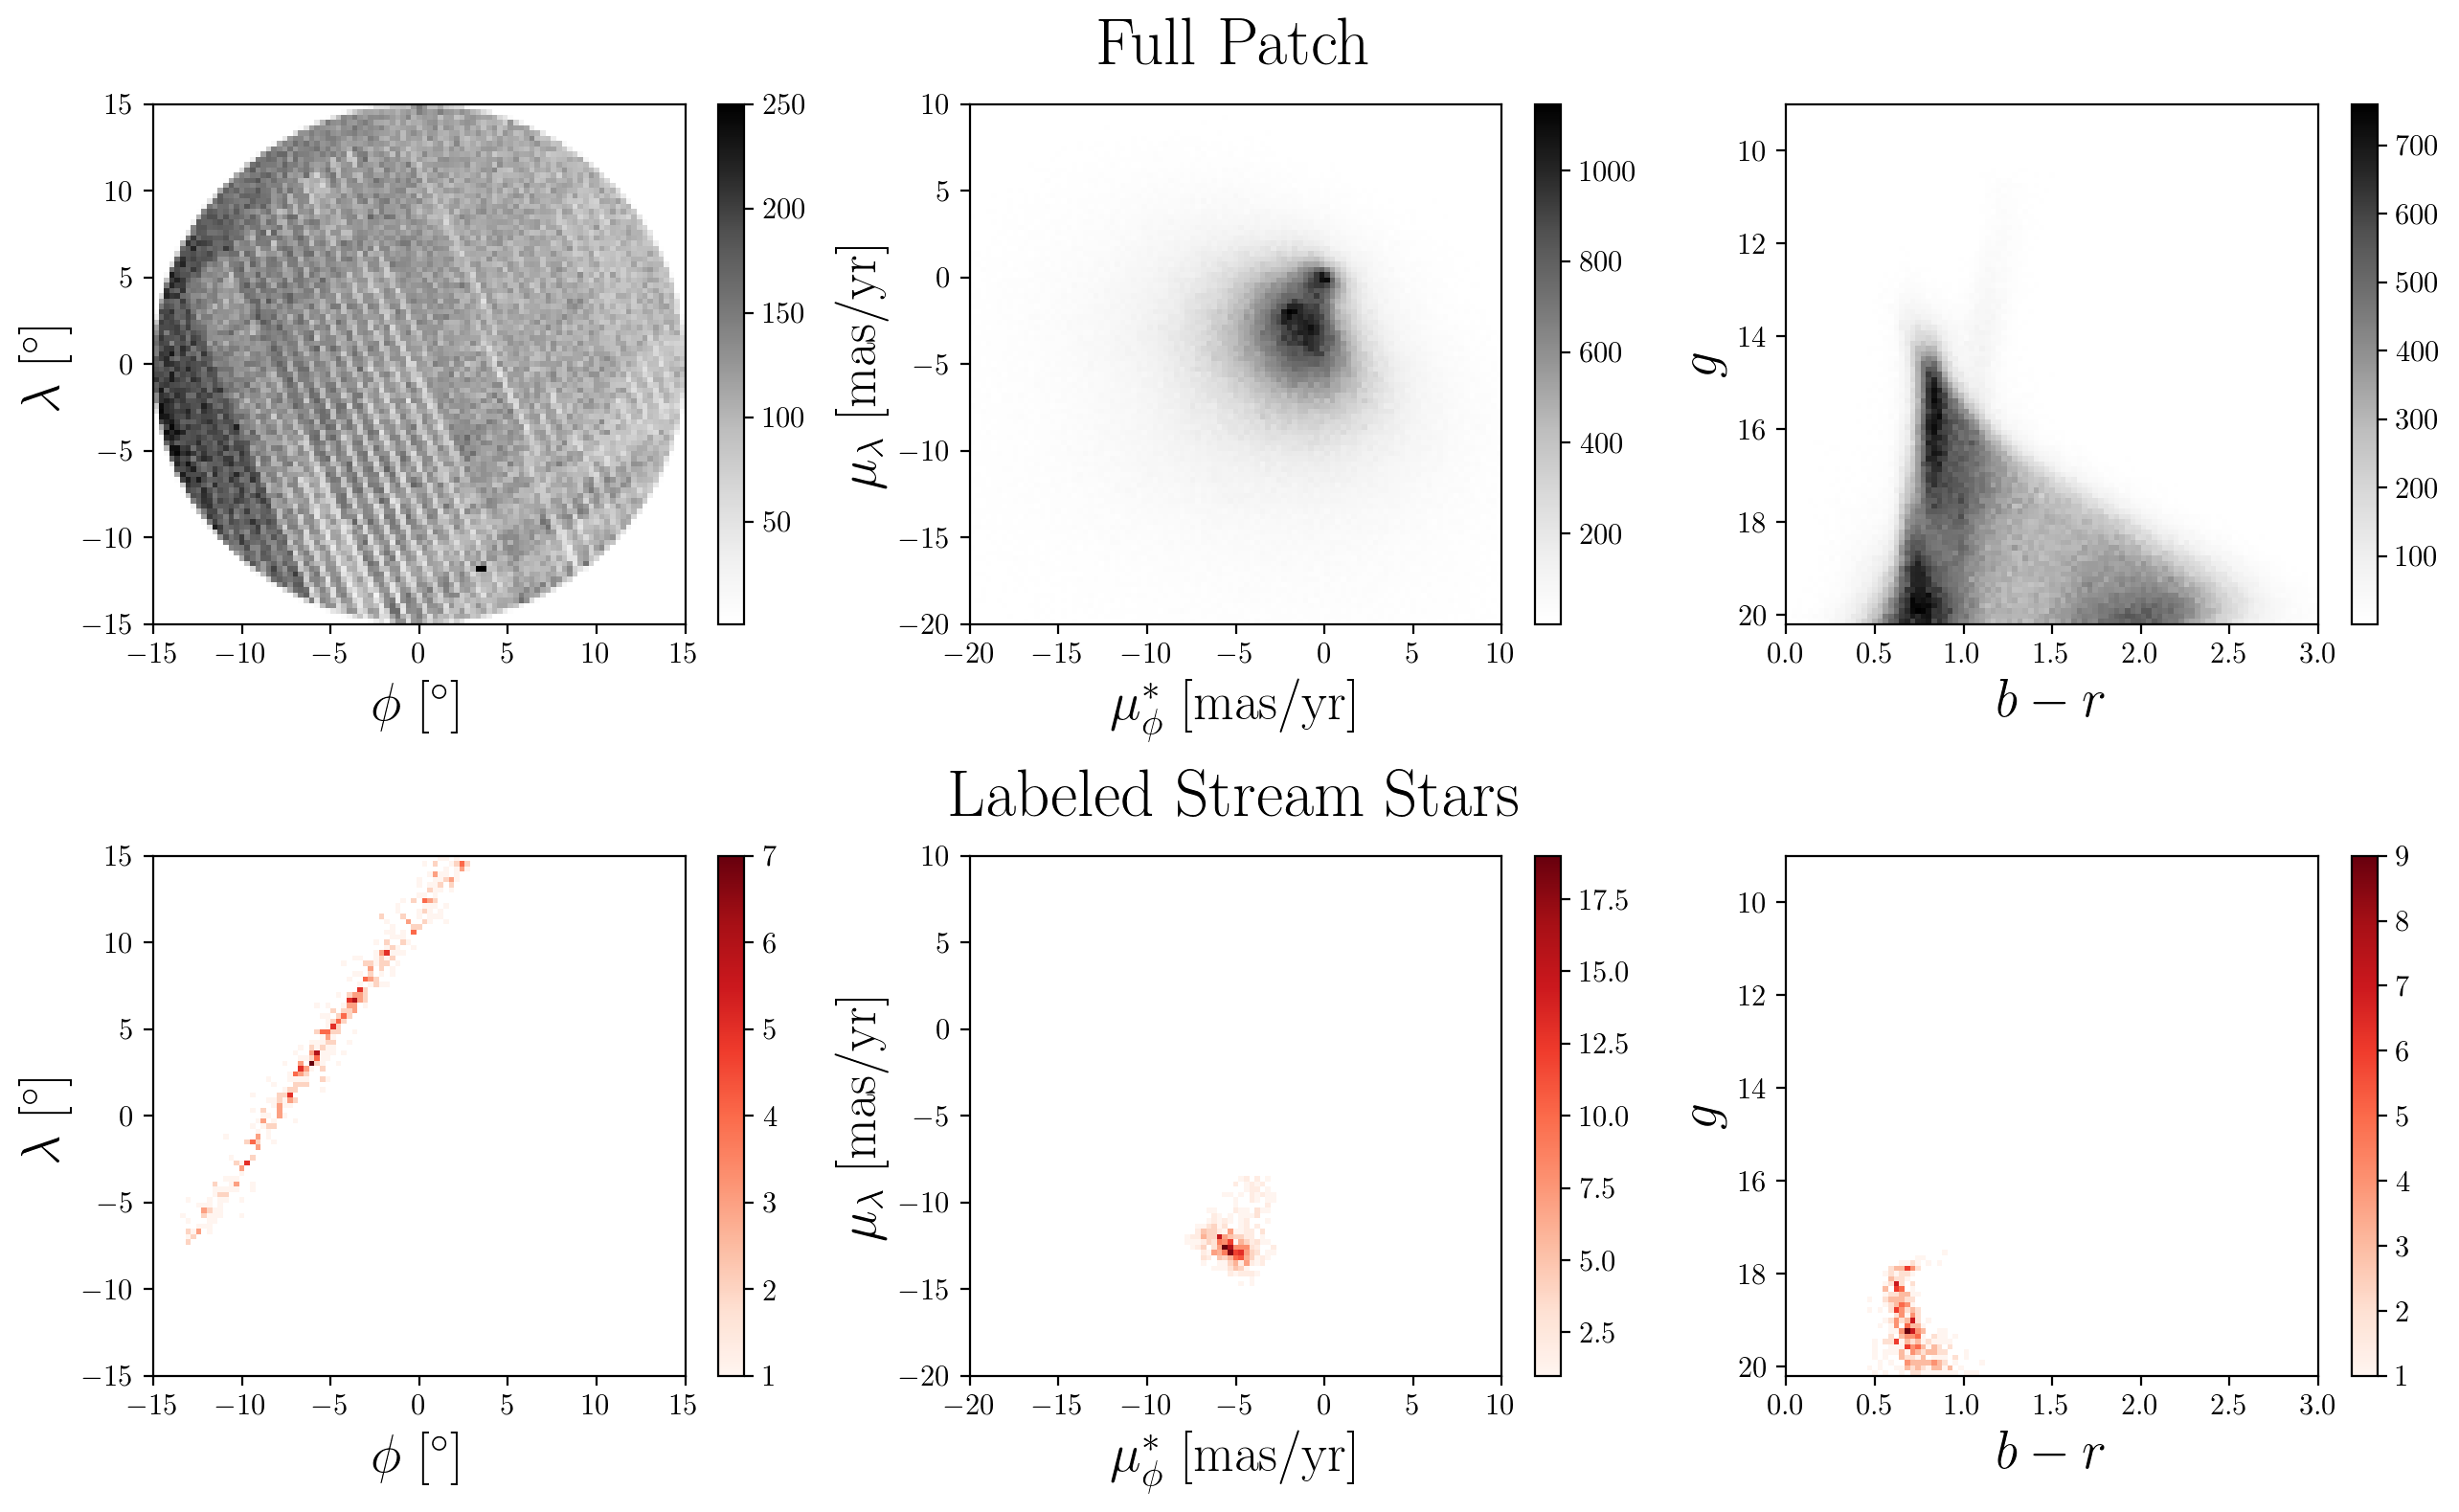

In [16]:
### Load file 
df = pd.read_hdf("../gaia_data/gd1_1_patch.h5")
make_plots(df, save_folder = save_folder)

Scanning over μ_λ
Sideband region: [-15.9,-13.6) & (-11.4,-9.1]
Signal region: [-13.6,-11.4]
Total counts: SR = 44,017, SB = 95,615
Signal region has 412 stream and 43,605 bkg events (0.94%).
Sideband region has 91 stream and 95,524 bkg events (0.10%).
f_sig = 9.9X f_sideband.


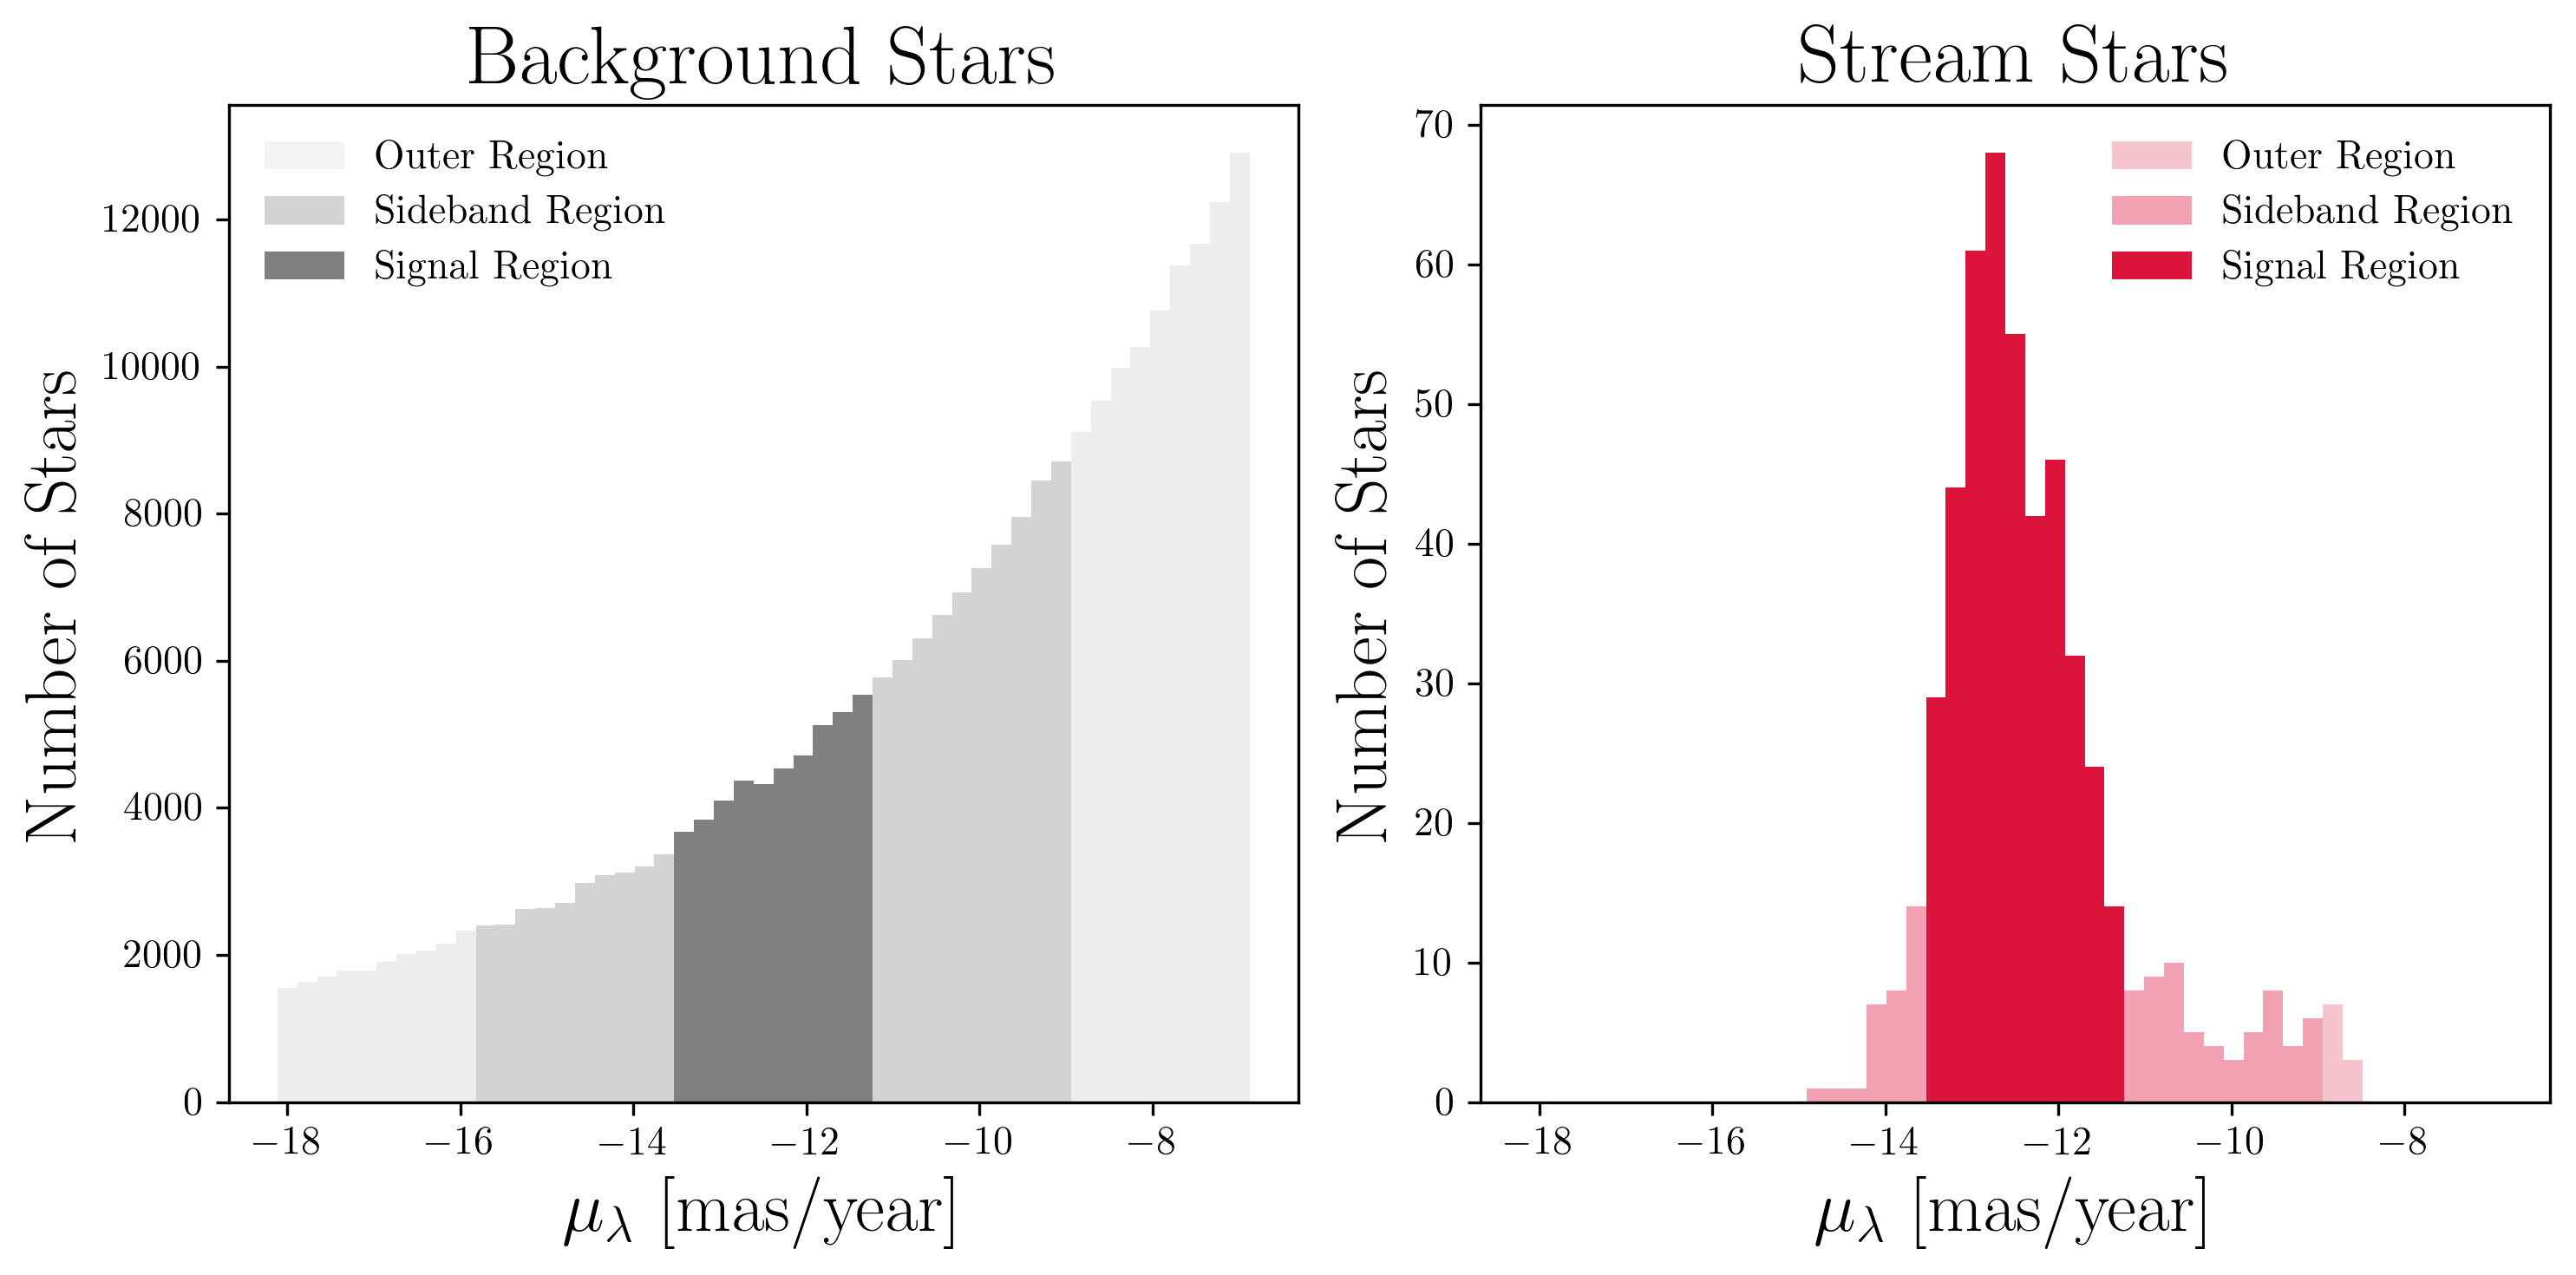

In [17]:
### Divide into signal & sideband regions
processor = SignalSideband(df,sr_factor=1, sb_factor=3,process=True)
df_slice = processor.df_slice
processor.plot_sb_data(save_folder=save_folder)


## Try to find another region?

In [21]:
# 1. Set up a grid
sr_factor_range = np.linspace(0.8, 2.5, 100)  # Modify the range and steps as needed
sb_factor_range = np.linspace(3, 6, 100)
SR, SB = np.meshgrid(sr_factor_range, sb_factor_range)

f_signal_ratio_vals = np.zeros(SR.shape)
sr_sb_ratio_vals = np.zeros(SR.shape)

# 2. Scan over the grid
processor = SignalSideband(df, verbose=False)  # Assuming df is your dataframe
for i in trange(SR.shape[0]):
    for j in range(SR.shape[1]):
        processor.set_factors( SB[i, j], SR[i, j], verbose=False, process=True)
        f_signal_ratio, sr_sb_ratio = processor.compute_ratios()
        
        f_signal_ratio_vals[i, j] = f_signal_ratio
        sr_sb_ratio_vals[i, j] = sr_sb_ratio


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:38<00:00,  2.79s/it]


/tmp/ipykernel_31926/1231418201.py:4: UserWarning: The following kwargs were not used by contour: 'interpolation'
  cs = plt.contourf(SR, SB, f_signal_ratio_vals,levels=50, cmap='viridis',interpolation='bilinear')


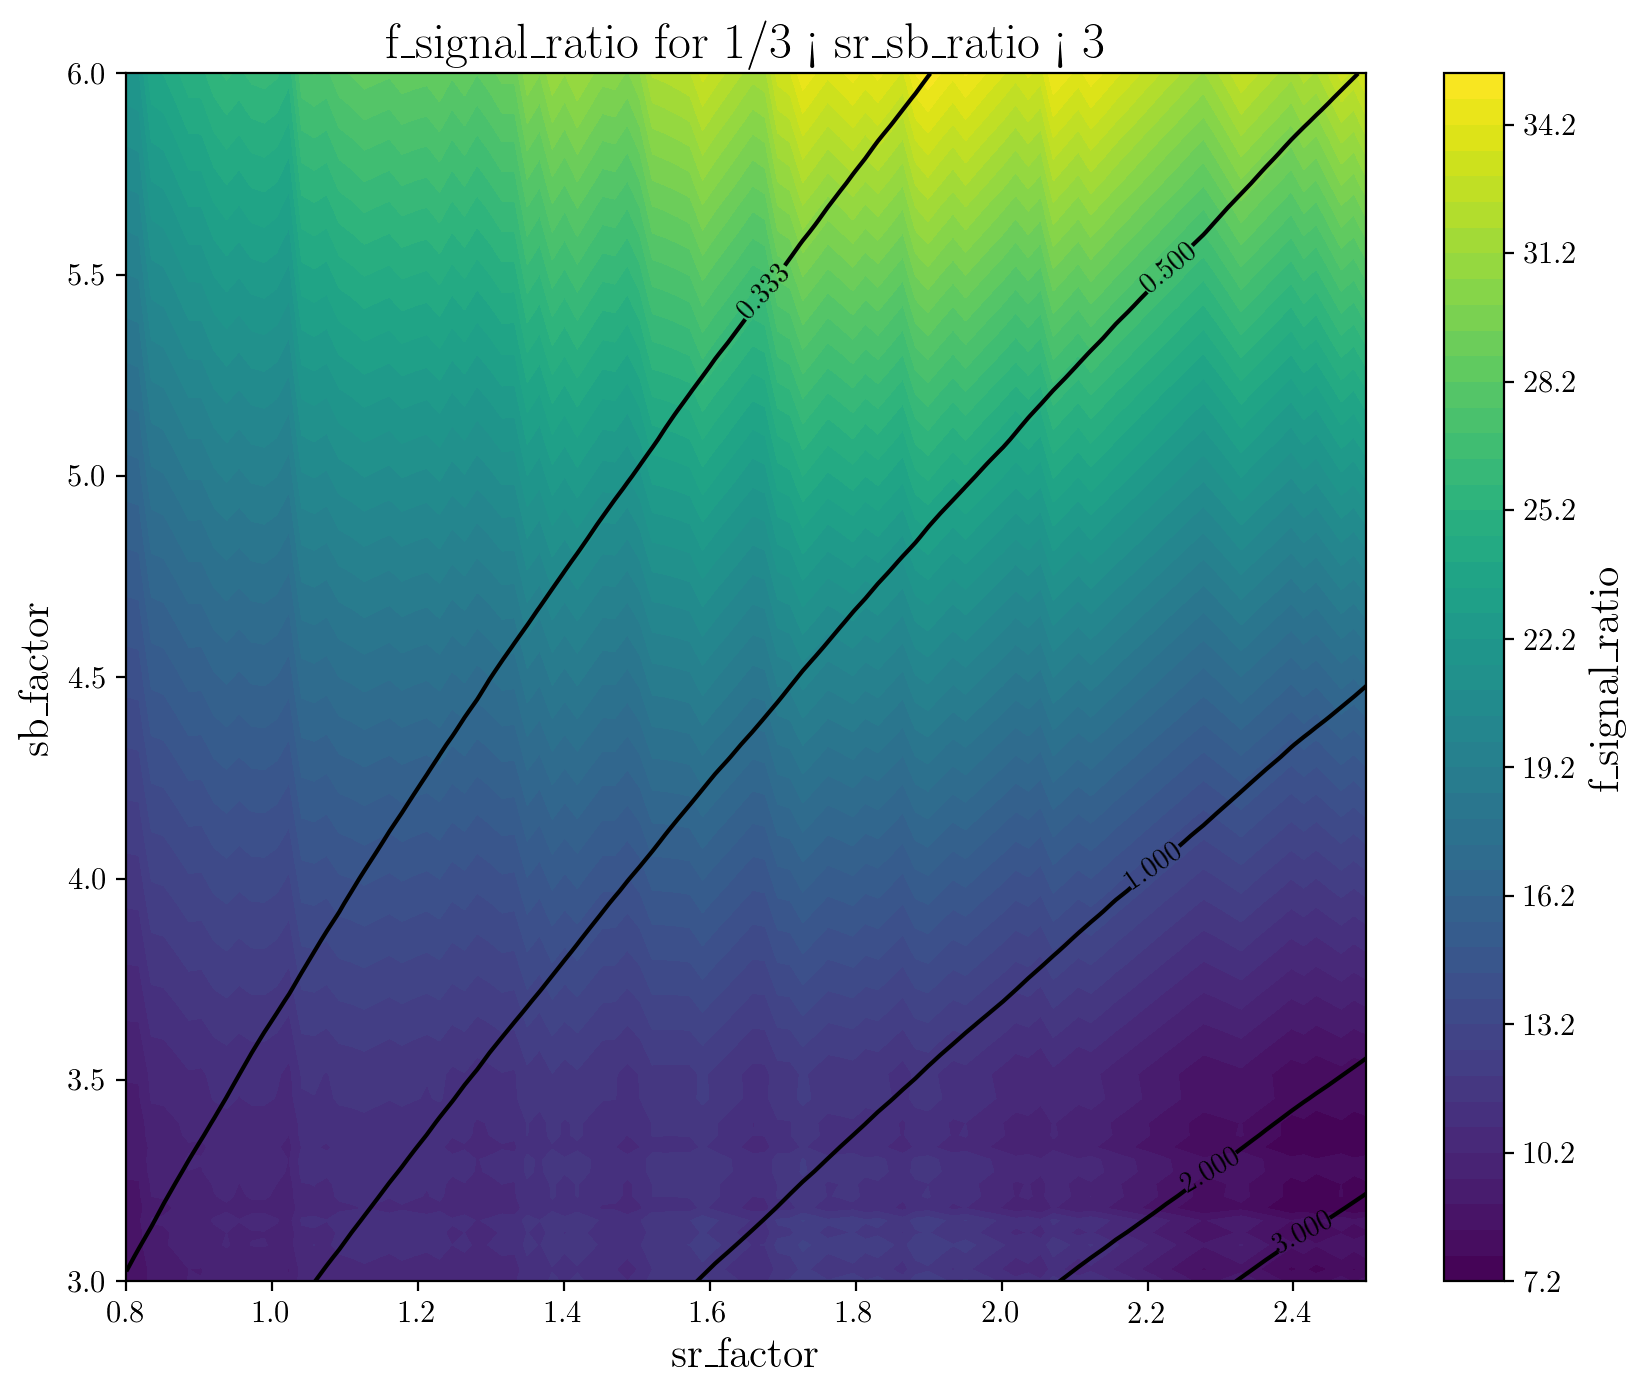

In [65]:
plt.figure(figsize=(10, 8))

# Create filled contour plot for f_signal_ratio_vals
cs = plt.contourf(SR, SB, f_signal_ratio_vals,levels=50, cmap='viridis',interpolation='bilinear')
# img = plt.imshow(f_signal_ratio_vals, aspect='auto', origin='lower', 
#                  extent=[sr_factor_range[0], sr_factor_range[1], 
#                          sb_factor_range[0], sb_factor_range[1]],
#                  cmap='viridis', interpolation='bilinear')  # choose an interpolation method that you prefer



# Overlay contour levels for sr_sb_ratio_vals
contour_levels = [1/3,1/2, 1, 2, 3]
cs_contour = plt.contour(SR, SB, sr_sb_ratio_vals, levels=contour_levels, colors='black')  # Black contour lines
plt.clabel(cs_contour, inline=1, fontsize=10, colors='black')  # to label the contours

# Colorbar
plt.colorbar(cs, label='f_signal_ratio')

plt.xlabel('sr_factor')
plt.ylabel('sb_factor')
plt.title('f_signal_ratio for 1/3 < sr_sb_ratio < 3')
plt.show()


### Train

2023-08-31 11:50:55.280510: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43672 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:c1:00.0, compute capability: 8.6


873/873 [==============================] - 1s 906us/step
Plotting results before fiducial cuts...
Plotting results after fiducial cuts...
873/873 [==============================] - 1s 992us/step
Plotting results before fiducial cuts...
Plotting results after fiducial cuts...
873/873 [==============================] - 1s 1ms/step
Plotting results before fiducial cuts...
Plotting results after fiducial cuts...
873/873 [==============================] - 1s 830us/step
Plotting results before fiducial cuts...
Plotting results after fiducial cuts...
873/873 [==============================] - 1s 825us/step
Plotting results before fiducial cuts...
Plotting results after fiducial cuts...


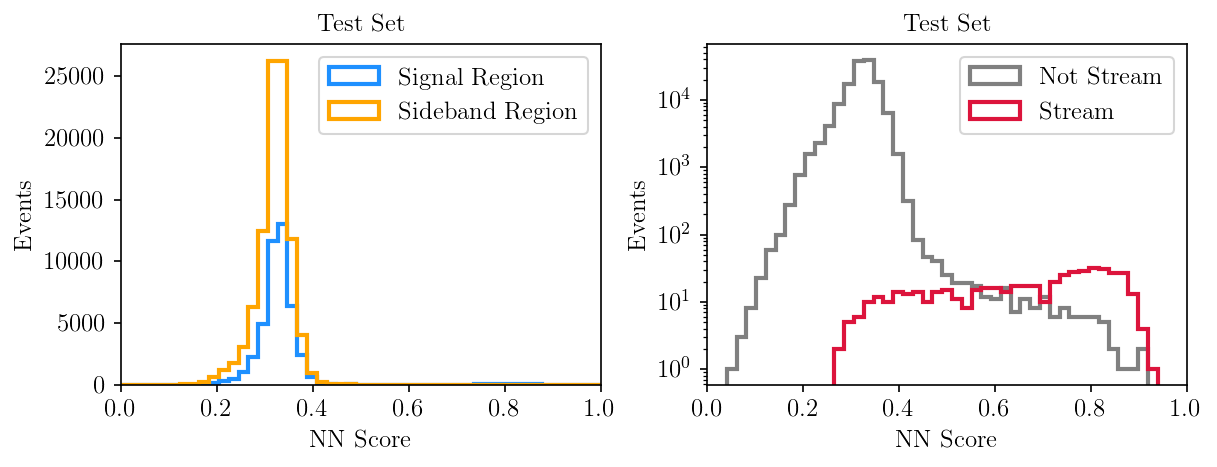

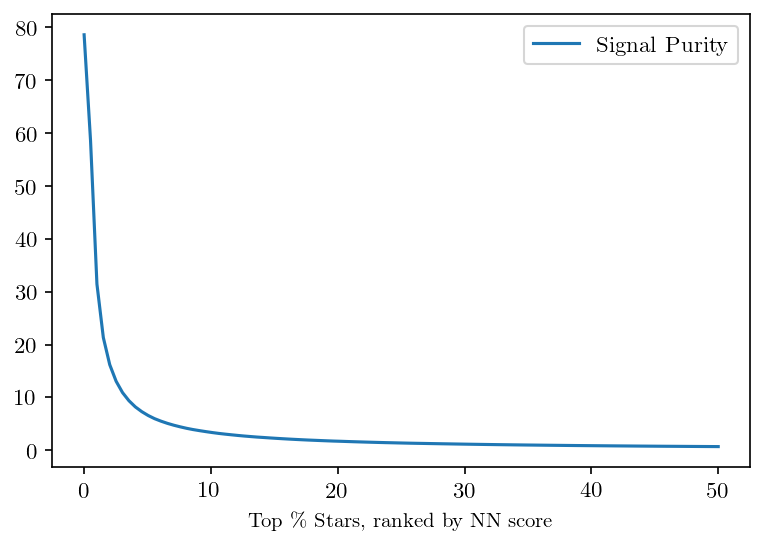

Top 50 stars: Purity = 92.0% 


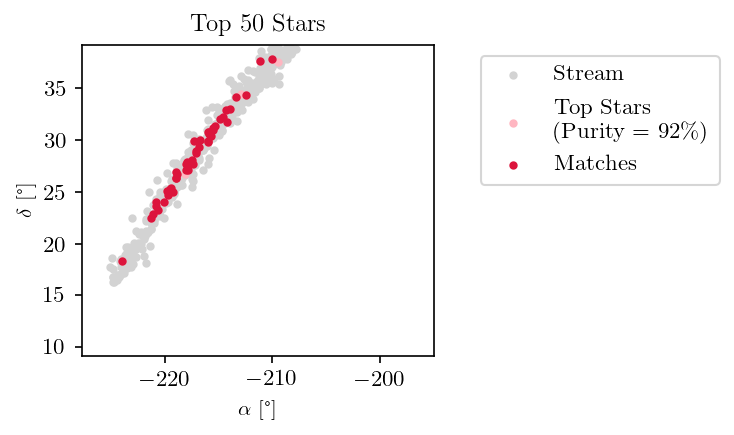

Top 100 stars: Purity = 91.0% 


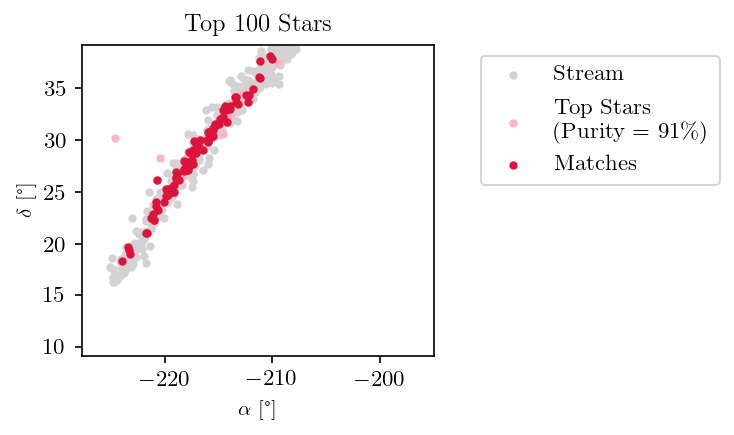

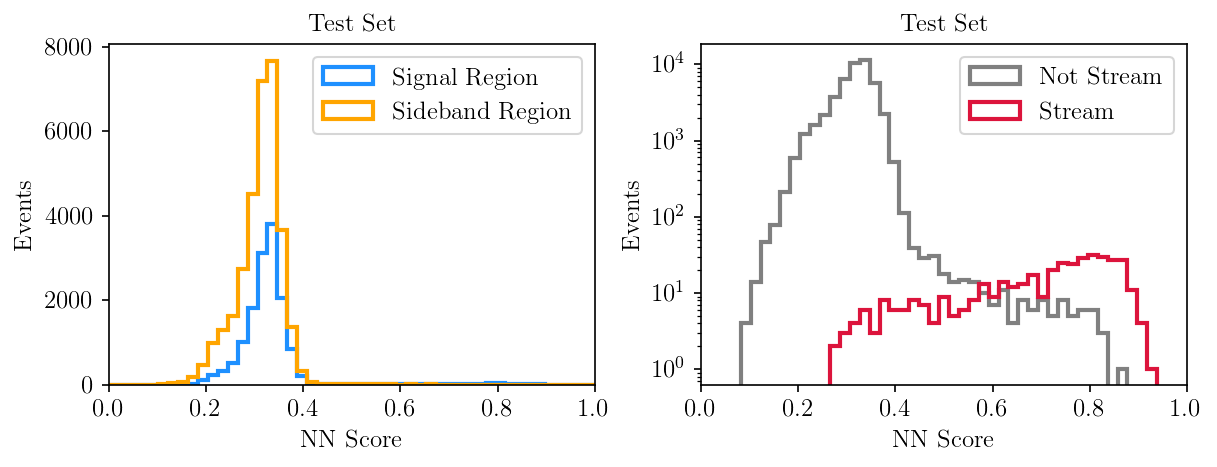

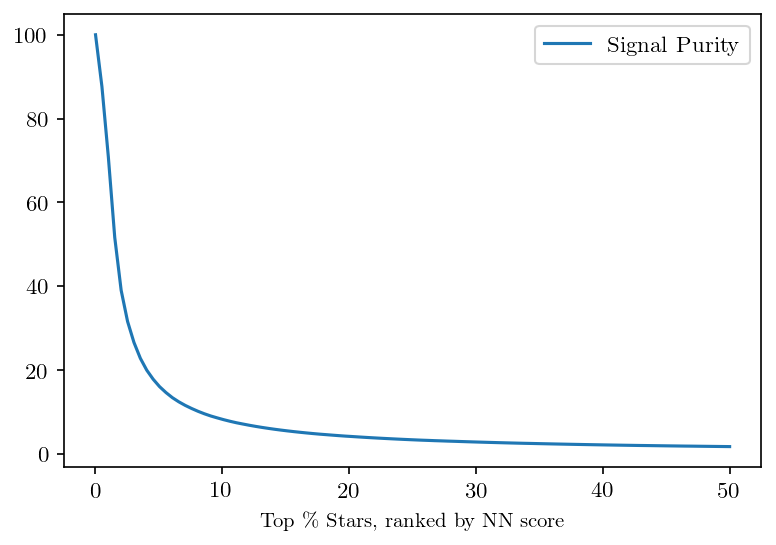

Top 50 stars: Purity = 98.0% 


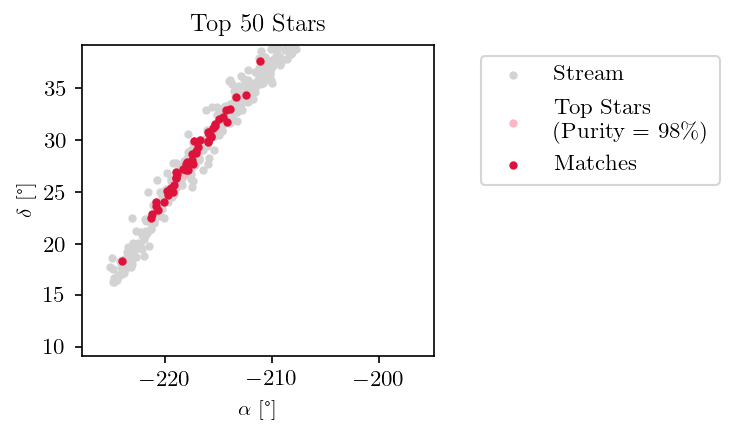

Top 100 stars: Purity = 97.0% 


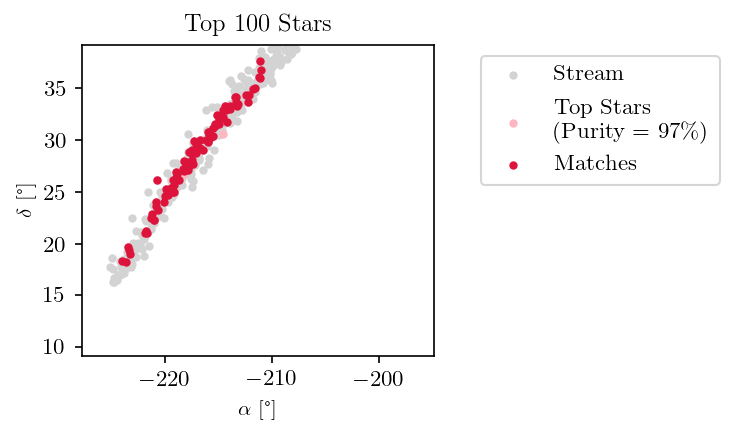

210.66258215904236

In [19]:
### Train 
start=time.time()
tf.keras.backend.clear_session()
test = train(df_slice, verbose=False, save_folder = save_folder)
time.time()- start

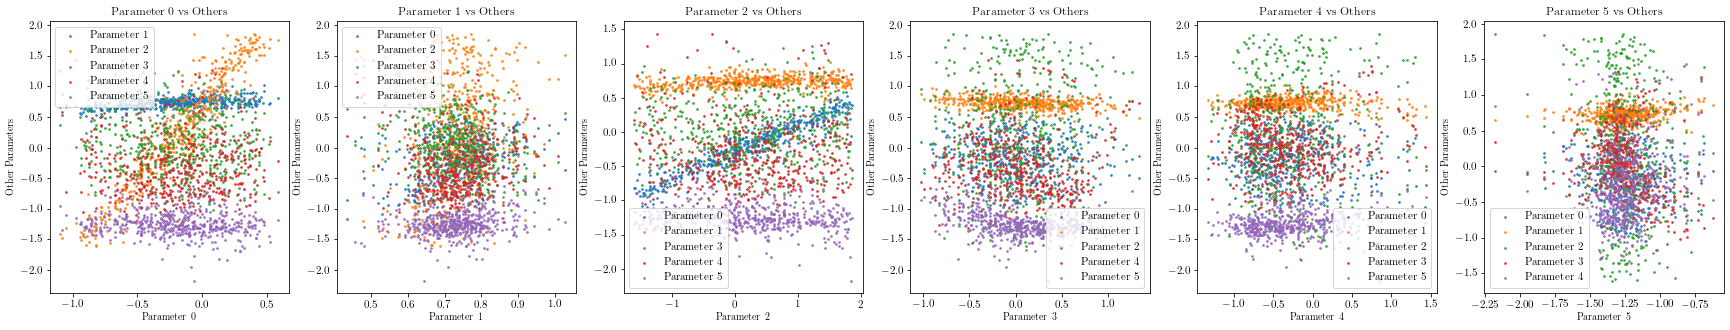

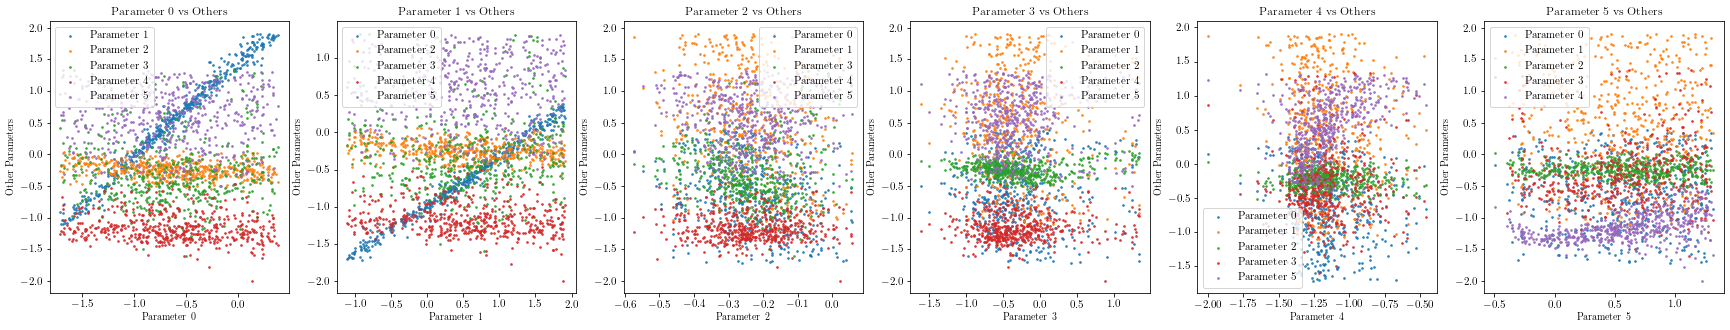

Index(['ϕ', 'λ', 'μ_ϕcosλ', 'μ_λ', 'b-r', 'g'], dtype='object')

In [163]:
ddf=pd.read_hdf('../notebooks/test_gd1/df_test.h5')

interest_vars=['ϕ', 'λ', 'μ_ϕcosλ', 'μ_λ', 'b-r', 'g']

design_mat = ddf[interest_vars]
score_vec = ddf['nn_score']
probs = score_vec / score_vec.sum()

# Compute weighted means
design_means = (design_mat.T * probs).sum(axis=1)

# Center the data
design_centered = design_mat.subtract(design_means)

# Compute weighted standard deviations
weighted_std = np.sqrt(((design_centered ** 2).multiply(probs, axis=0)).sum(axis=0))

# Standardize the data
design_standardized = design_centered.divide(weighted_std, axis=1)


cov_mat=design_standardized.multiply(probs, axis=0).T @ design_centered
eigenvalues, eigenvectors = np.linalg.eig(cov_mat)
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

rotated_design=((design_standardized @ sorted_eigenvectors))



twd_d=rotated_design[ddf['stream']].values.T
twd_d_0=design_standardized[ddf['stream']].values.T

fig, axs = plt.subplots(1, 6, figsize=(30, 5))  # 1 row, 5 columns

for i in range(6):  # Looping through the first 5 parameters
    axs[i].set_title(f'Parameter {i} vs Others')
    
    for j in range(6):  # Looping through all 6 parameters
        if i != j:
            axs[i].scatter(twd_d[i], twd_d[j], alpha=0.8, s=3, label=f'Parameter {j}')
            
    axs[i].set_xlabel(f'Parameter {i}')
    axs[i].set_ylabel('Other Parameters')
    axs[i].legend()

plt.show()

fig, axs = plt.subplots(1, 6, figsize=(30, 5))  # 1 row, 5 columns
for i in range(6):  # Looping through the first 5 parameters
    axs[i].set_title(f'Parameter {i} vs Others')
    
    for j in range(6):  # Looping through all 6 parameters
        if i != j:
            axs[i].scatter(twd_d_0[i], twd_d_0[j], alpha=0.8, s=3, label=f'Parameter {j}')
            
    axs[i].set_xlabel(f'Parameter {i}')
    axs[i].set_ylabel('Other Parameters')
    axs[i].legend()

plt.show()
design_mat.columns

# plt.matshow(sorted_eigenvectors, cmap=plt.cm.Blues)
# plt.colorbar(label='Value')
# plt.show()


In [181]:
twd_d.shape

(6, 503)

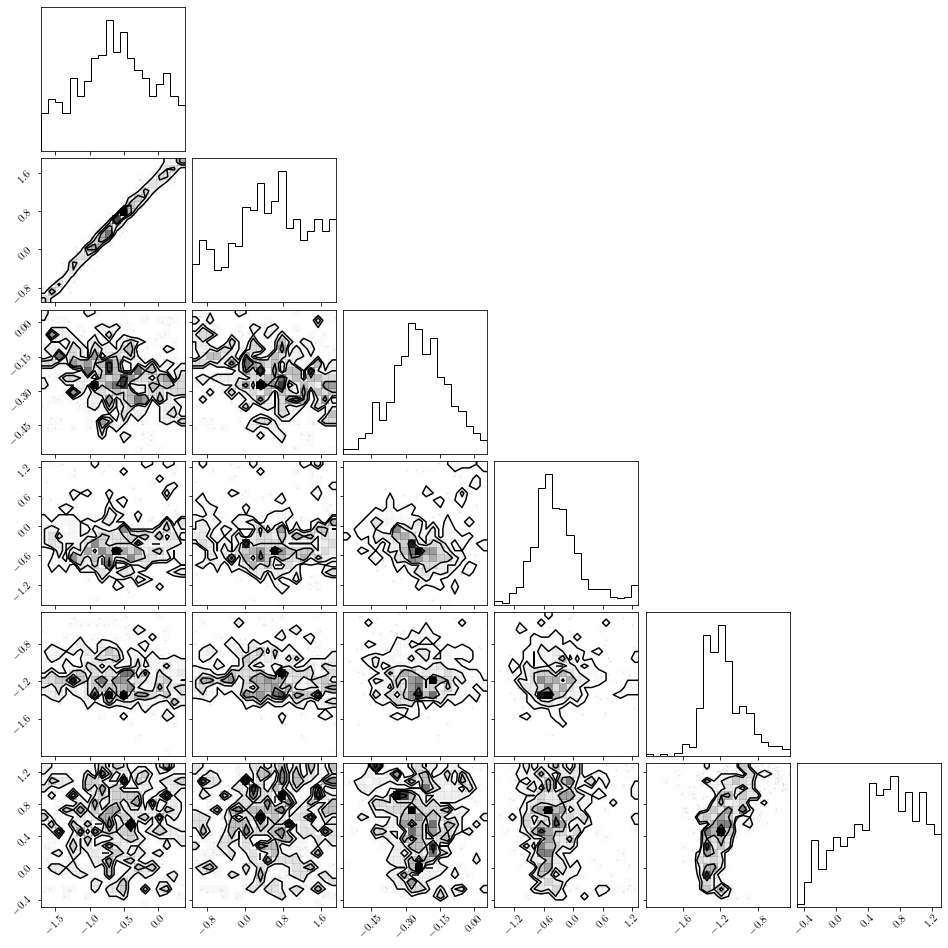

In [184]:


fig = corner.corner(twd_d_0.T)

# Show the plot
plt.show()

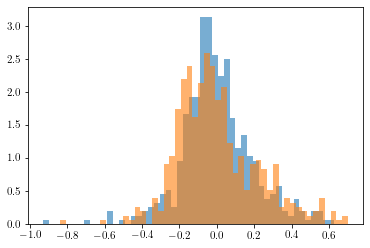

(0.03668997218273272, 0.2774931573474917)

In [193]:
plt.hist(twd_d[5]-np.mean(twd_d[5]),bins=50,density=True,alpha=0.6)
plt.hist(twd_d_0[4]-np.mean(twd_d_0[4]),bins=50,density=True,alpha=0.6)
plt.show()

np.var(twd_d[5]),np.var(twd_d_0[0])

In [132]:
for i in range(6):
    for j in range(i+1,6):
        print(i,j)

0 1
0 2
0 3
0 4
0 5
1 2
1 3
1 4
1 5
2 3
2 4
2 5
3 4
3 5
4 5


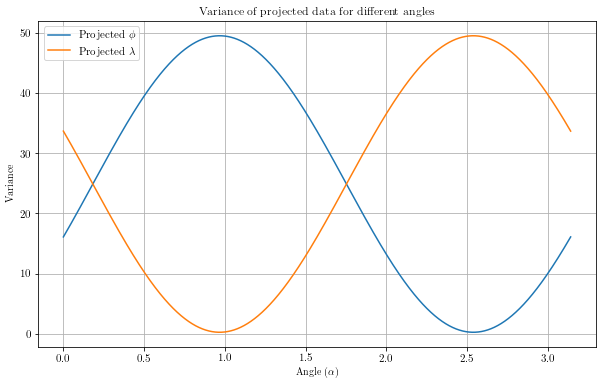

In [6]:

# Define a range of angles from 0 to pi/2 (since after pi/2 the rotations will just mirror the data)
angles = np.linspace(0, np.pi, 10000)

def rot_mat(angle):
    s=np.sin(angle)
    c=np.cos(angle)
    mat=np.array([[c,s],[-s,c]])
    return mat

rotation_matrices=np.array([rot_mat(a) for a in angles])


# 2. Project the data using matrix multiplication
data_array = df.query('stream')[['ϕ', 'λ']].values.T  # shape (2, num_points)
projected_data = np.einsum('aij,jk->aik', rotation_matrices, data_array)  # shape (num_angles, 2, num_points)

# 3. Calculate variance for each projected data
variances = np.var(projected_data, axis=2)

# 4. Plot variances as a function of angles
plt.figure(figsize=(10, 6))
plt.plot(angles, variances[:, 0], label=r'Projected $\phi$')
plt.plot(angles, variances[:, 1], label=r'Projected $\lambda$')
plt.xlabel(r'Angle ($\alpha$)')
plt.ylabel(r'Variance')
plt.legend()
plt.title(r'Variance of projected data for different angles')
plt.grid(True)
plt.show()


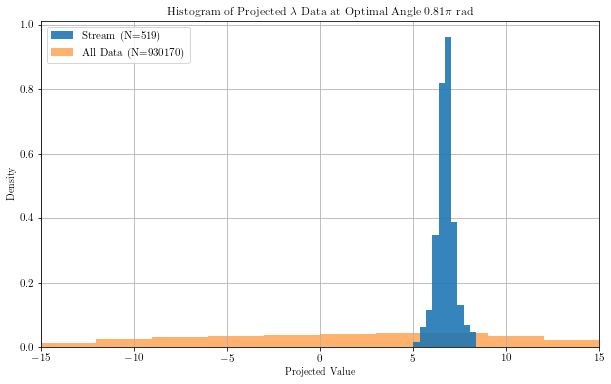

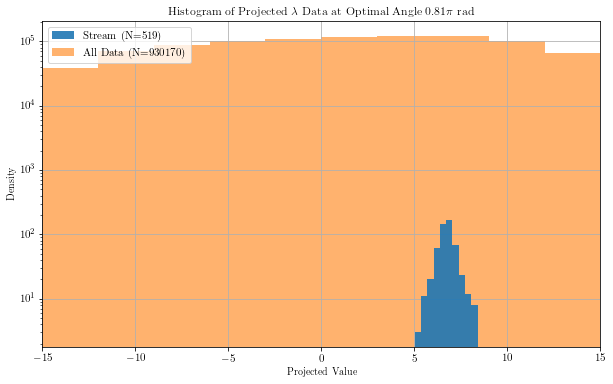

In [13]:
# Find the angle which minimizes the variance of the projected lambda values
optimal_angle_index = np.argmin(variances[:, 0])
optimal_rotation_matrix = rotation_matrices[optimal_angle_index]

# Project data using the optimal rotation matrix
projected_stream = np.dot(df.query('stream')[['ϕ', 'λ']].values, optimal_rotation_matrix.T)
projected_all = np.dot(df[['ϕ', 'λ']].values, optimal_rotation_matrix.T)

# Get number of stars in stream and all data
num_stream = projected_stream.shape[0]
num_all = projected_all.shape[0]

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(projected_stream[:, 0], alpha=0.9, label=f"Stream (N={num_stream})", density=True,zorder=100)
plt.hist(projected_all[:, 0], alpha=0.6, label=f"All Data (N={num_all})",  density=True)

plt.xlabel(r'Projected Value')
plt.ylabel(r'Density')
plt.title(f'Histogram of Projected $\lambda$ Data at Optimal Angle {angles[optimal_angle_index]/np.pi:.2f}$\pi$ rad')
plt.legend()
plt.xlim(-15,15)
plt.grid(True)
plt.show()

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(projected_stream[:, 0], alpha=0.9, label=f"Stream (N={num_stream})",zorder=100)
plt.hist(projected_all[:, 0], alpha=0.6, label=f"All Data (N={num_all})")

plt.xlabel(r'Projected Value')
plt.ylabel(r'Density')
plt.title(f'Histogram of Projected $\lambda$ Data at Optimal Angle {angles[optimal_angle_index]/np.pi:.2f}$\pi$ rad')
plt.yscale('log')
plt.legend()
plt.xlim(-15,15)
plt.grid(True)
plt.show()

In [17]:
# Make a copy of the dataframe
df_rot = df.copy()

# Assign the projected values
df_rot[['ϕ', 'λ']] = projected_all

# Swap values between ϕ and μ_λ
original_μ_λ = df['μ_λ'].copy()
df_rot['μ_λ'] = df_rot['ϕ']
df_rot['ϕ'] = original_μ_λ


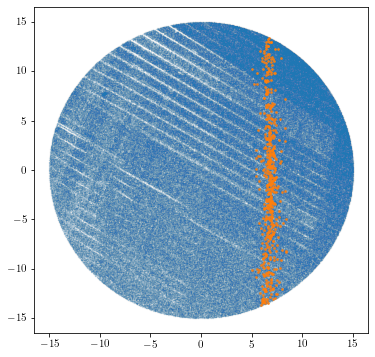

In [20]:
plt.figure(figsize=(6,6))
plt.scatter(*df_rot[['μ_λ', 'λ']].values.T,alpha=0.4,s=0.003)
plt.scatter(*df_rot.query('stream')[['μ_λ', 'λ']].values.T,alpha=0.8,s=3)
plt.show()

Scanning over μ_λ
Sideband region: [3.2,5.7) & (7.7,10.2]
Signal region: [5.7,7.7]
Total counts: SR = 80,707, SB = 194,806
Signal region has 483 stream and 80,224 bkg events (0.60%).
Sideband region has 36 stream and 194,770 bkg events (0.02%).
f_sig = 32.6X f_sideband.


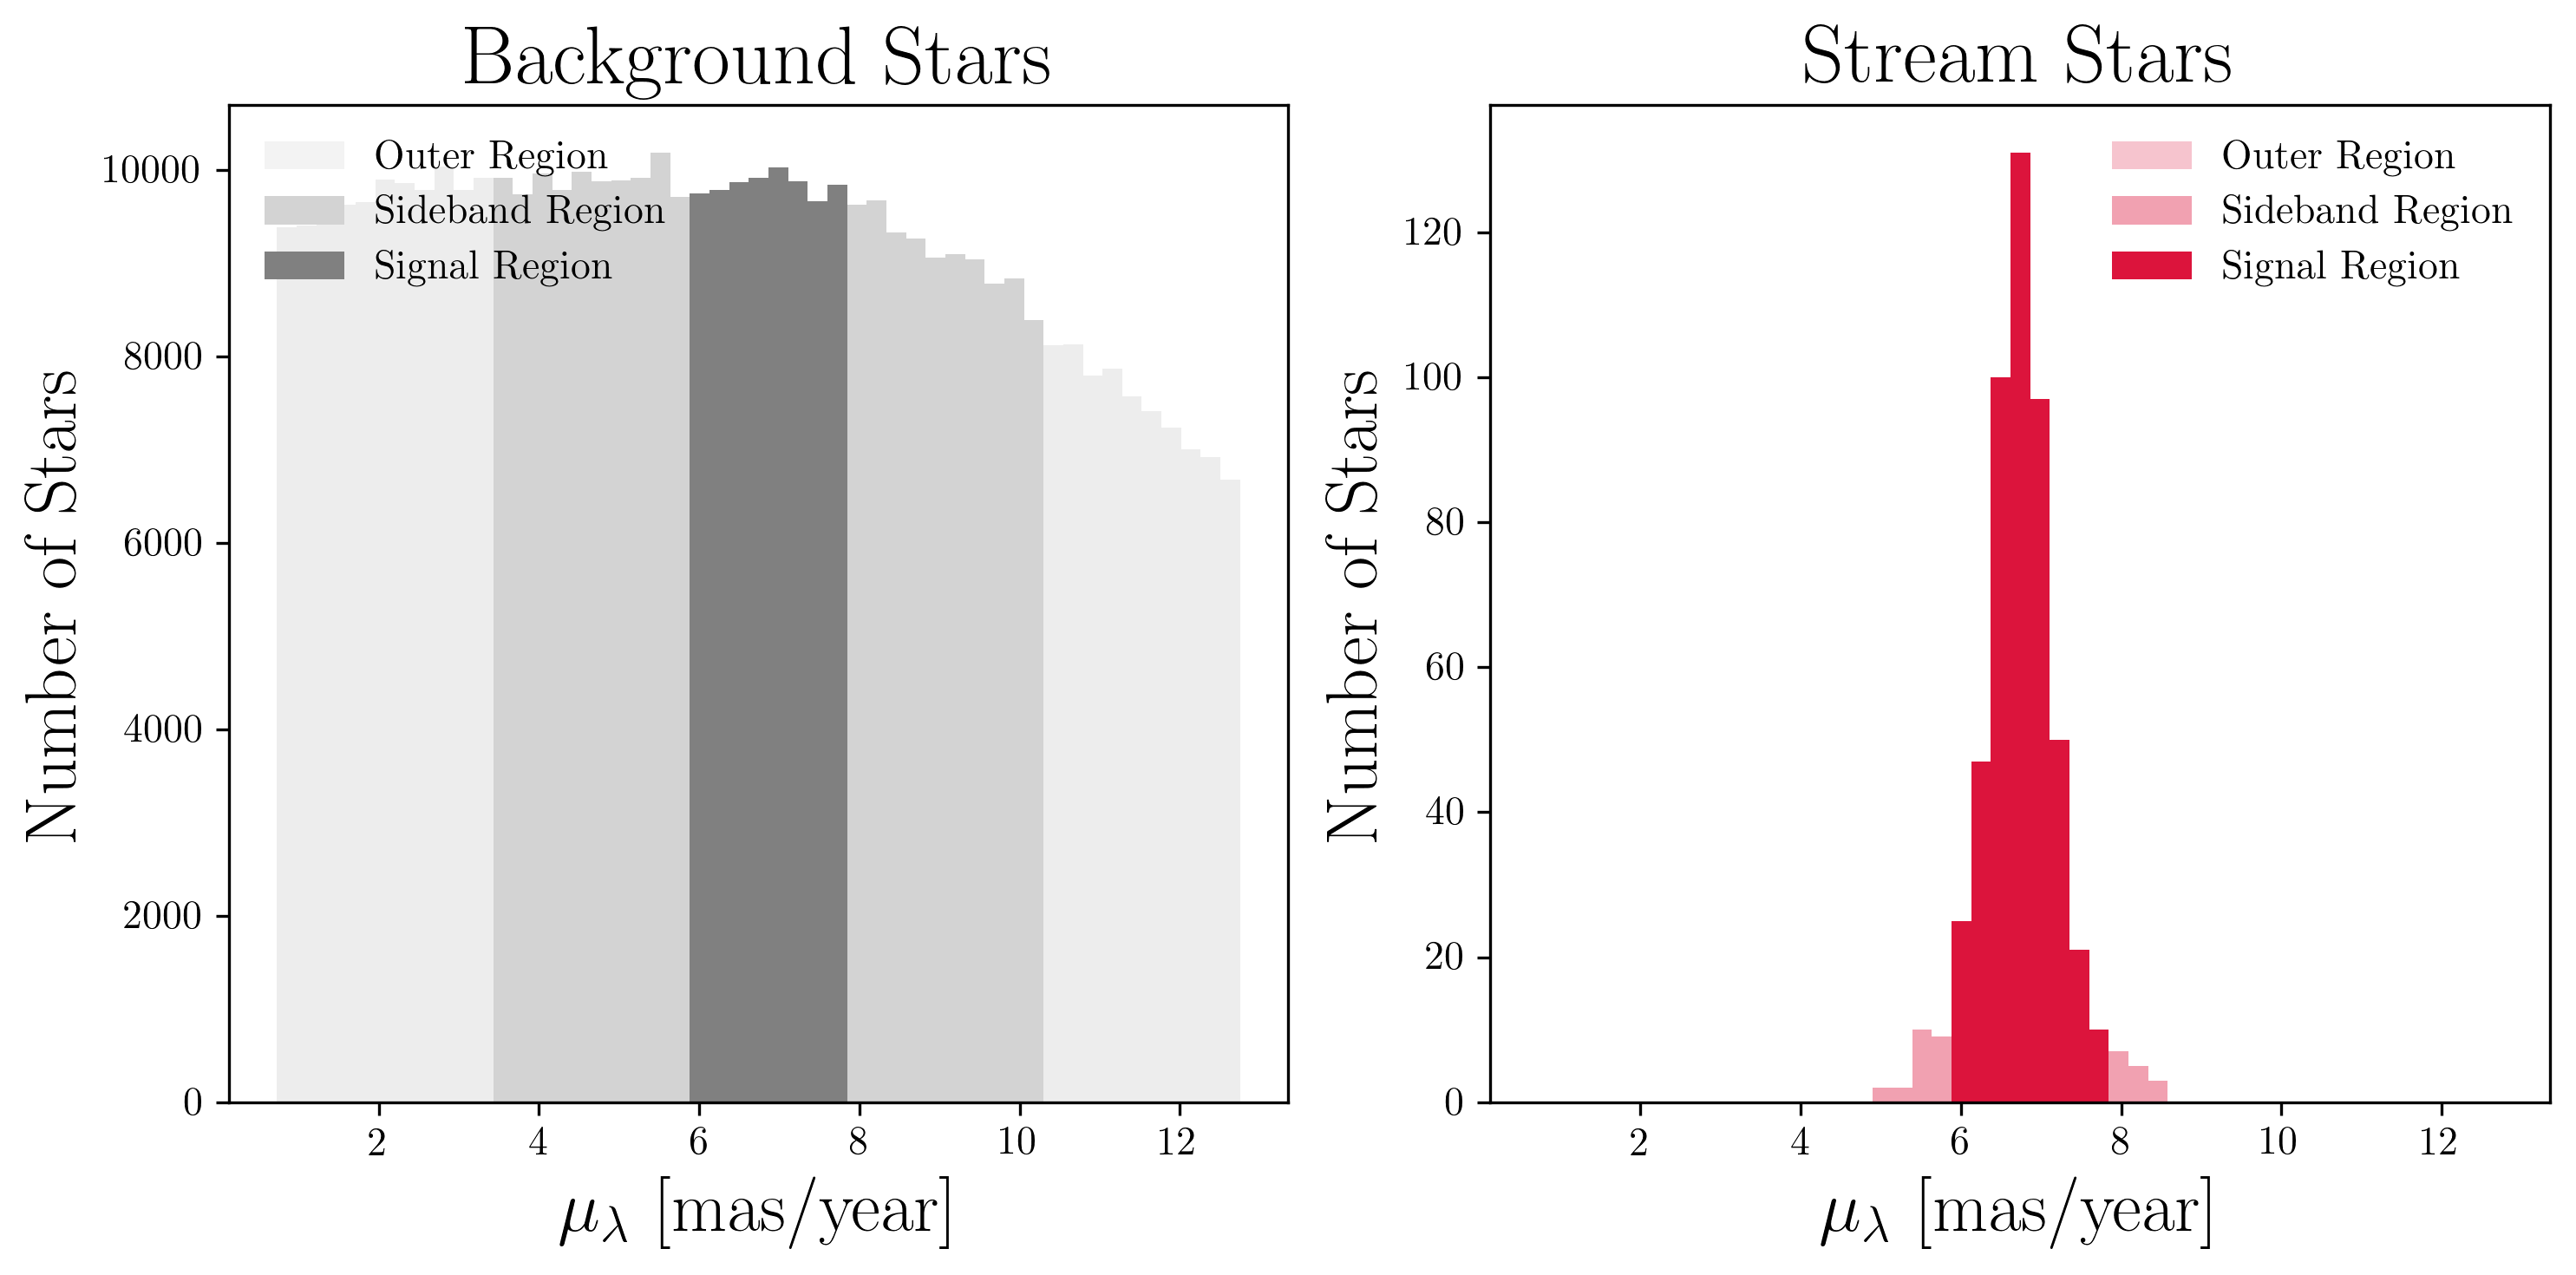

In [36]:
processor = SignalSideband(df_rot,sr_factor=2, sb_factor=7,process=True)
df_slice = processor.df_slice
processor.plot_sb_data()

1722/1722 [==============================] - 2s 886us/step
Plotting results before fiducial cuts...
Plotting results after fiducial cuts...
1722/1722 [==============================] - 1s 783us/step
Plotting results before fiducial cuts...
Plotting results after fiducial cuts...
1722/1722 [==============================] - 1s 797us/step
Plotting results before fiducial cuts...
Plotting results after fiducial cuts...
1722/1722 [==============================] - 2s 1ms/step
Plotting results before fiducial cuts...
Plotting results after fiducial cuts...
1722/1722 [==============================] - 2s 853us/step
Plotting results before fiducial cuts...
Plotting results after fiducial cuts...


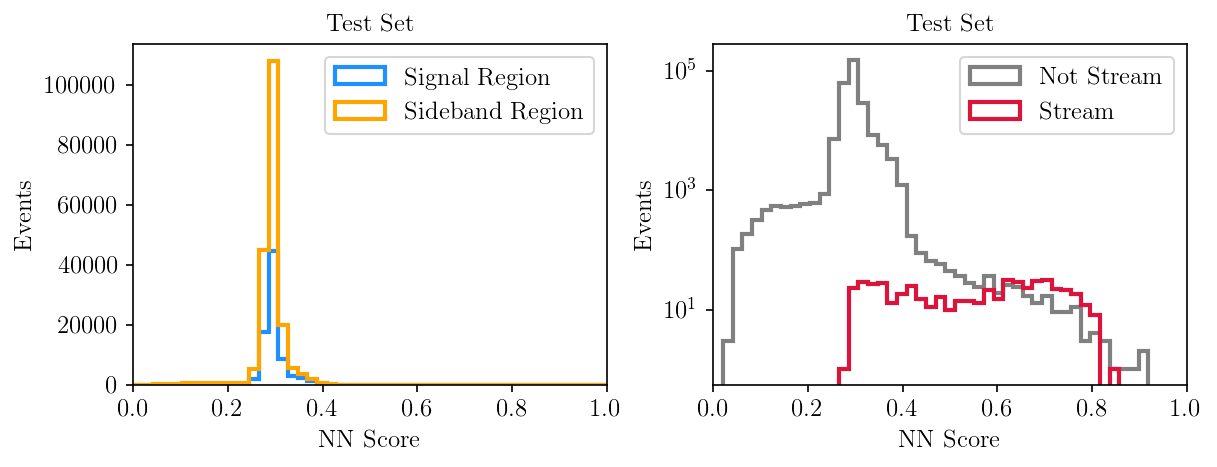

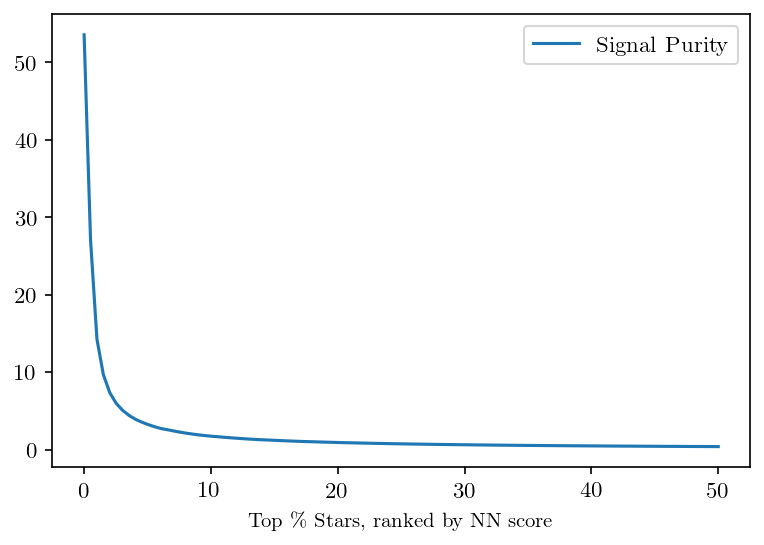

Top 50 stars: Purity = 66.0% 


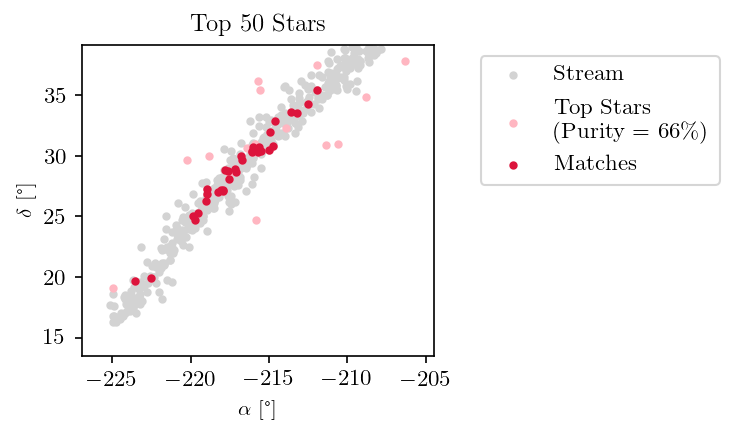

Top 100 stars: Purity = 63.0% 


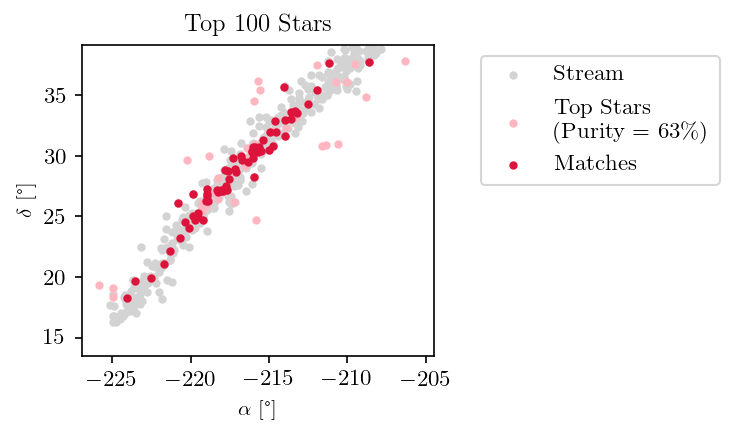

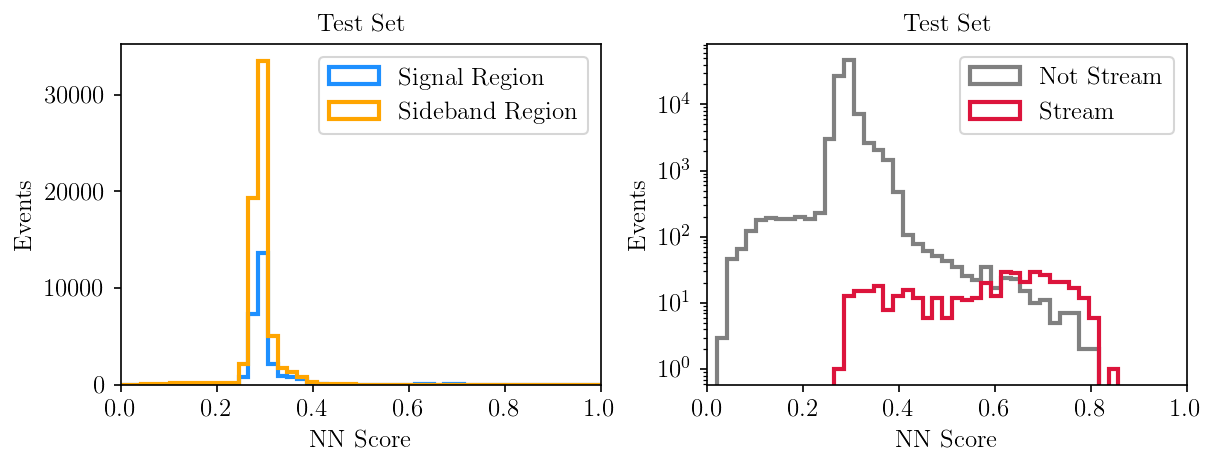

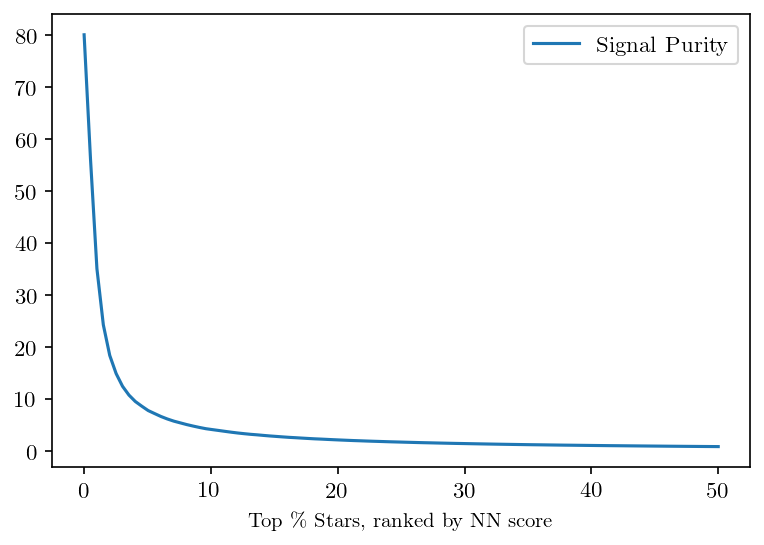

Top 50 stars: Purity = 76.0% 


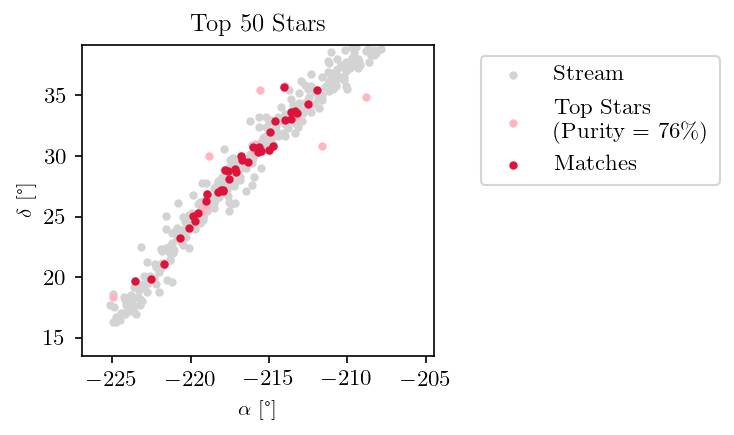

Top 100 stars: Purity = 77.0% 


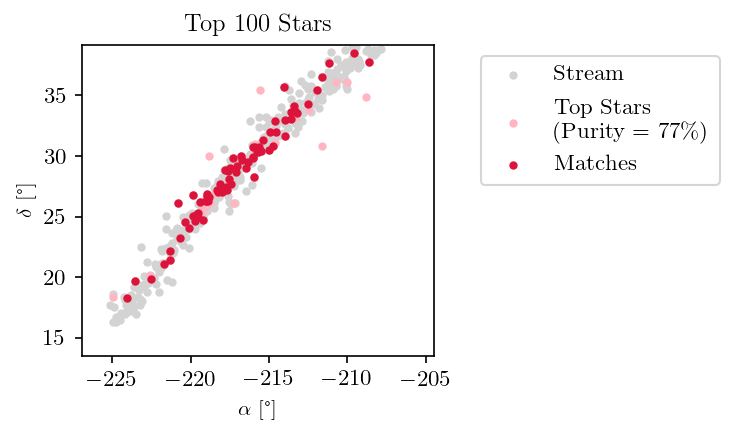

In [41]:
### Train 
tf.keras.backend.clear_session()
test = train(df_slice, verbose=False, save_folder = save_folder)